## Variational Autoencoder: hyperparameter tuning, training and analysis.

Repetimos el workflow implementado con el AutoEncoder Convolucional, pero ahora utilizando el modelo variacional. La idea es ver cómo difiere la representación de las unidades del espacio latente.

In [1]:
import os
import pickle
import warnings

from kneed import KneeLocator
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay, PiecewiseConstantDecay
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tqdm import tqdm

from src.data.create_data import load_data
from src.features.preprocess_data import to_dB, remove_outliers, RScaler_beta
from src.models.saving import save_configuration, load_configuration
from src.models.select_model import k_fold_cv
from src.models.model_wrappers import build_cae_architecture, build_vae_architecture
from src.models.variational_autoencoder import VariationalAutoencoder
from src.visualization.visualize import plot_polarization_signature, plot_history


2023-02-11 22:15:36.673155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 22:15:37.955255: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-02-11 22:15:37.955382: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-02-11 22:15:37.955390: W tensorflow/compiler/tf2tensorrt/utils/py_uti

### 1. Ajuste de hiperparámetros

Cargamos datos crudos, preprocesamos y separamos en conjuntos de entrenamiento y testeo. Luego hacemos un grid search para encontrar el mejor set de parámetros del modelo.

In [2]:
# Cargamos los datos crudos
raw_data = load_data("raw/spm_signatures_no_noise")
print(f"Shape de los datos: {raw_data.shape}")

# Removemos outliers y pasamos a dB
data_dB = to_dB(remove_outliers(raw_data, k=100))
print(f"Número de muestras luego de remover outliers: {len(data_dB)}")

Shape de los datos: (20480, 45, 90)
Número de muestras luego de remover outliers: 6219


In [3]:
train_set, test_set = train_test_split(
    data_dB,
    test_size=.2,
    random_state=123
)

print(f"Tamaño de los datos de entrenamiento: {train_set.shape}")
print(f"Tamaño de los datos de testeo: {test_set.shape}")

Tamaño de los datos de entrenamiento: (4975, 45, 90)
Tamaño de los datos de testeo: (1244, 45, 90)


Definimos las posibles arquitecturas junto con el resto de los hyperparametros

In [4]:
# Fijamos la dimensión del espacio latente
LATENT_DIMENTION = 10
INPUT_SHAPE = train_set.shape[1:]

# Configuracion de las capas convolucionales
cv_layers = [
    [(4, (7, 8), 2), (4, (5, 5), 1)],
    [(4, (3, 4), 2), (4, (3, 3), 1)],
    [(4, (3, 4), 2), (4, (3, 3), 1), (4, (3, 3), 1)],
    [(4, (3, 4), 2), (4, (4, 4), 2), (4, (3, 3), 1)],
    [(4, (3, 4), 2), (8, (3, 3), 1)],
    [(4, (3, 3), 1), (4, (3, 3), 1)],
    [(4, (3, 4), 2), (4, (4, 4), 2)],
    [(4, (3, 4), 2), (16, (4, 4), 2)],
    [(4, (3, 4), 2), (8, (4, 4), 2), (16, (3, 3), 1)],
]

# Configuración de las capas densas
dense_layers = [
    (16,), (64,), (128), (256,),
    (32, 16), (16, 16), (32, 32),
    (256, 128)
 ]

Definida la grilla, iteramos sobre cada elemenro de la misma  y hacemos k-fold cross vaidation con k=5 para cada configuración. 

In [5]:
# Primero chequeamos que TensorFlow detecte la gpu
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
configurations_score = []
best_configuration = {'score' : 1e4}
not_tested_configuration = []

for cv_layer in tqdm(cv_layers):
    for dense_layer in dense_layers:

        # Configuración del modelo
        conv_configuration = dict(
            layers_config=cv_layer,
            kernel_initializer='glorot_uniform'
        )

        dense_configuration = dict(
            layers_units=dense_layer,
        )                

        configuration = {
            'conv_layers_config': conv_configuration, 
            'dense_layers_config': dense_configuration, 
            'batch_size': 16
        }

        # k-fold cross validation
        try:
            k_fold_score = k_fold_cv(
                train_set, build_vae_architecture, configuration
            )
        
        except tf.errors.ResourceExhaustedError:
            # En el caso de agotar los recursos
            not_tested_configuration.append(configuration)
            
            warnings.warn(
                ('La actual configuración agotó los recursos '
                f'de memoria y no fue evaluada: \n {configuration}'), 
                RuntimeWarning
                )

        else:
            # Actualizo los scores de las configuraciones
            configuration.update(k_fold_score)
            configurations_score.append(configuration)
                
            if configuration['score'] < best_configuration['score']:
                best_configuration = configuration 
        
        finally:
            continue     

 11%|█         | 1/9 [1:56:44<15:33:53, 7004.15s/it]

: 

: 

In [ ]:
df_scores = pd.DataFrame.from_records(configurations_score).sort_values(by='score')
df_scores['conv_layers_config'] = df_scores['conv_layers_config'].apply(lambda x: x['layers_config'])
df_scores['dense_layers_config'] = df_scores['dense_layers_config'].apply(lambda x: x['layers_units'])
df_scores

Guardo los scores y la arquitectura con mejor score

In [ ]:
# Get resutls directory path
src_dir = os.path.normpath(os.getcwd() + '/..')
results_dir = os.path.join(src_dir, 'results/spm')

# File name and dir
file_name = 'vae_architectures_scores.pkl'
file_dir = os.path.join(results_dir, file_name)

# Save model_scores as pkl
with open(file_dir, 'wb') as f:
    pickle.dump(configurations_score, f)

In [ ]:
save_configuration(
    best_configuration, 
    filename='vae_architecture'
    )

Configuration saved at /home/jotavecorta/proyectos/tesis/src/models/model_architecture_spm.json


In [ ]:
best_configuration.pop("score")
best_configuration.pop("train_score")
print(best_configuration)

Ahora que tenemos la mejor arquitectura, probamos agregar maxpooling, dropout, earlystopping y variar el learning rate.

In [ ]:
pooling_options = [True, False]
dropout_options = [True, False]

configurations_score = []
not_tested_configuration = []

for pooling in tqdm(pooling_options):
    for dropout in dropout_options:

        # Configuración del modelo
        configuration = best_configuration
        configuration['conv_layers_config'].update(
             {'max_pooling' : pooling}
             )   
        configuration['dense_layers_config'].update(
            {'dropout' : dropout}
            )  

        # k-fold cross validation
        try:
            k_fold_score = k_fold_cv(
                train_set, build_vae_architecture, configuration
            )
        
        except tf.errors.ResourceExhaustedError:
            # En el caso de agotar los recursos
            not_tested_configuration.append(configuration)
            
            warnings.warn(
                ('La actual configuración agotó los recursos '
                f'de memoria y no fue evaluada: \n {configuration}'), 
                RuntimeWarning
                )

        else:
            # Actualizo los scores de las configuraciones
            configuration.update(k_fold_score)
            configurations_score.append(configuration)
        
        finally:
            continue 

In [ ]:
df_scores = pd.DataFrame.from_records(configurations_score).sort_values(by='score')
df_scores['conv_layers_config'] = df_scores['conv_layers_config'].apply(lambda x: x['layers_config'])
df_scores['dense_layers_config'] = df_scores['dense_layers_config'].apply(lambda x: x['layers_units'])
df_scores

In [ ]:
best_configuration = dict(df_scores.iloc[0])
print(best_configuration) 

In [ ]:
save_configuration(
    best_configuration, 
    filename='vae_architecture'
    )

Configuramos el optimizador del gradient descent

In [ ]:
initial_value=0.002
final_value=0.0001, 
train_samples=train_set.shape[0],
epochs=200, 
batch_size=32

# Set TensorFlow seed for reproducible results
tf.random.set_seed(123)

# Continous decay parameters
decay_rate = (initial_value - final_value)/epochs
decay_steps = int(train_samples / batch_size) 
total_steps = decay_steps*epochs
inverse_decay_steps = (final_value*decay_rate*total_steps / 
                        (initial_value - final_value))

# Piecewise decay parameters
steps = 6
step_len = int(total_steps / steps)
step_decay = (initial_value - final_value) / steps

schedulers_type = {
    'polynomial' : PolynomialDecay(
        initial_learning_rate=initial_value, 
        decay_steps=total_steps, 
        end_learning_rate=final_value, 
        power=3
        ), 
    'step' : PiecewiseConstantDecay(
        boundaries=[bound for bound in range(step_len, total_steps, step_len)],
        values=[value for value in np.arange(initial_value, final_value, -step_decay)]
        ),
    'inverse' : InverseTimeDecay(
        initial_learning_rate=initial_value, 
        decay_steps=inverse_decay_steps, 
        decay_rate=decay_rate,
        ), 
    'exponential' : ExponentialDecay(
        initial_learning_rate=initial_value,
        decay_steps=total_steps,
        decay_rate=final_value/initial_value
        ),
    'constant' : initial_value / 2
    }

optimizers = [tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adam]

In [ ]:
configurations_score = []
not_tested_configuration = []

for opt in tqdm(optimizers):
    for scheduler in schedulers_type:
        # Copy configuration to share with model
        configuration = best_configuration        

        # Configuración del modelo
        best_configuration.update({
            "optimizer" : opt(learning_rate=scheduler),
        })

        # k-fold cross validation
        try:
            k_fold_score = k_fold_cv(
                train_set, build_vae_architecture, configuration
            )
        
        except tf.errors.ResourceExhaustedError:
            # En el caso de agotar los recursos
            not_tested_configuration.append(configuration)
            
            warnings.warn(
                ('La actual configuración agotó los recursos '
                f'de memoria y no fue evaluada: \n {configuration}'), 
                RuntimeWarning
                )

        else:
            # Actualizo los scores de las configuraciones
            best_configuration.update(k_fold_score)
            configurations_score.append(configuration)
        
        finally:
            continue 

In [ ]:
best_configuration = dict(df_scores.iloc[0])
print(best_configuration) 

In [ ]:
save_configuration(
    best_configuration, 
    filename='vae_architecture'
    )

Entrenamos el mejor modelo para ver cómo reproduce los datos.

In [ ]:
# Escaleamos las imagenes
scaler = RScaler_beta().fit(train_set)
scaled_test = np.expand_dims(scaler.transform(test_set), axis=-1)
scaled_train = np.expand_dims(scaler.transform(train_set), axis=-1)

# 
var_cae = VariationalAutoencoder(
    LATENT_DIMENTION, 
    INPUT_SHAPE,
    conv_layers=best_configuration['conv_layers_config'],
    dense_layers=best_configuration['dense_layers_config'],
    )  

var_cae.compile(optimizer='adam', loss=tf.losses.MeanSquaredError())

history = var_cae.fit(
    scaled_train, 
    scaled_train,
    epochs = 200,
    batch_size = 32,
    verbose = 0,
    validation_data=(scaled_test, scaled_test)
    )

plot_history(history, metric="mean_squared_error")

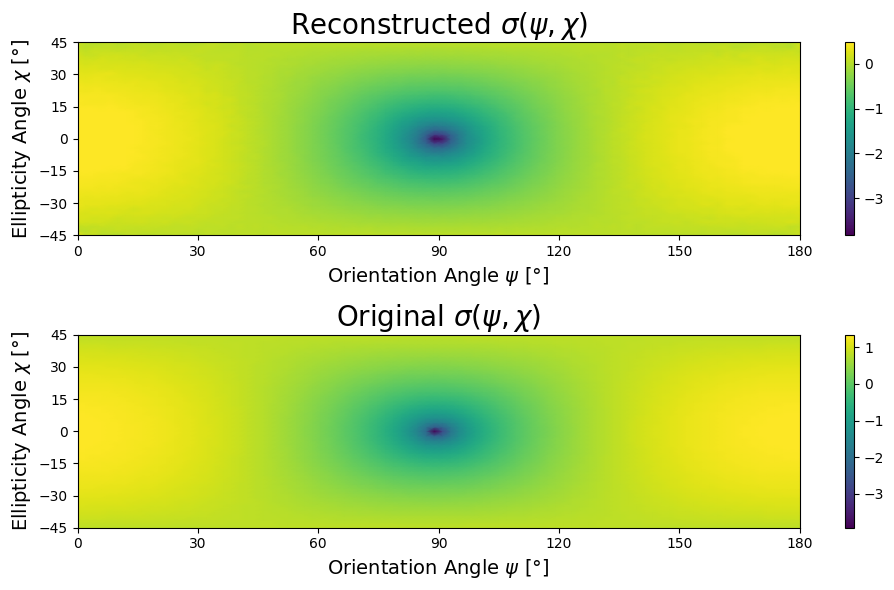

In [ ]:
# Reconstruimos las firmas
Z = var_cae.encoder(scaled_test)
Z_mean = var_cae._latent_mean(Z)
Z_var = var_cae._latent_log_var(Z)
encoded_imgs = var_cae._sampling(Z_mean, Z_var)
decoded_imgs = var_cae.decoder(encoded_imgs).numpy()

# Elegimos ana firma al azar
rng = np.random.default_rng()
rnd_index = rng.integers(decoded_imgs.shape[0])
rnd_reconstruct_signature = decoded_imgs[rnd_index, :, :, 0]
rnd_signature = scaled_test[rnd_index, :, :, 0]

# Ploteamos
fig, ax = plt.subplots(2, 1)

plot_polarization_signature(rnd_reconstruct_signature, ax=ax[0])
plot_polarization_signature(rnd_signature, ax=ax[1])

ax[0].set_title(r'Reconstructed $\sigma(\psi,\chi)$', fontsize = 20)
ax[1].set_title(r'Original $\sigma(\psi,\chi)$', fontsize = 20)

fig.tight_layout()

Generamos nuevs firmas sampleando el espacio latente: armamos una gaussiana con media y varianza correspondientes a las del espacio latente.

### 2. Minimización del espacio latente

Ahora que contamos con un modelo optimizado, buscamos la cantidad mínima de neuronas para la cuál el modelo sigue reconstruyendo los datos.

In [ ]:
vae_configuration = load_configuration("vae_architecture")

In [ ]:
# Initialize list for results
models_scores = []
not_tested_configurations = []

config_keys = ('conv_layers_config', 'dense_layers_config')

for lat_dim in tqdm(range(1, 17)):
    configuration = {keys : vae_configuration[keys] for keys in config_keys}
    configuration.update({"latent_dimension" : lat_dim})
    configuration.update({"batch_size" : 16})

    try:
        k_fold_score = k_fold_cv(
            train_set, 
            build_vae_architecture, 
            configuration
            )
    
    except tf.errors.ResourceExhaustedError:
        # If gpu memory is exhausted
        not_tested_configurations.append(configuration)
        
        raise Warning(('La actual configuración agotó los recursos '
        f'de memoria y no fue evaluada: \n {configuration}'))  
    
    else:
        # Update scores
        configuration.update(k_fold_score)
        models_scores.append(configuration)

    finally:
        continue   

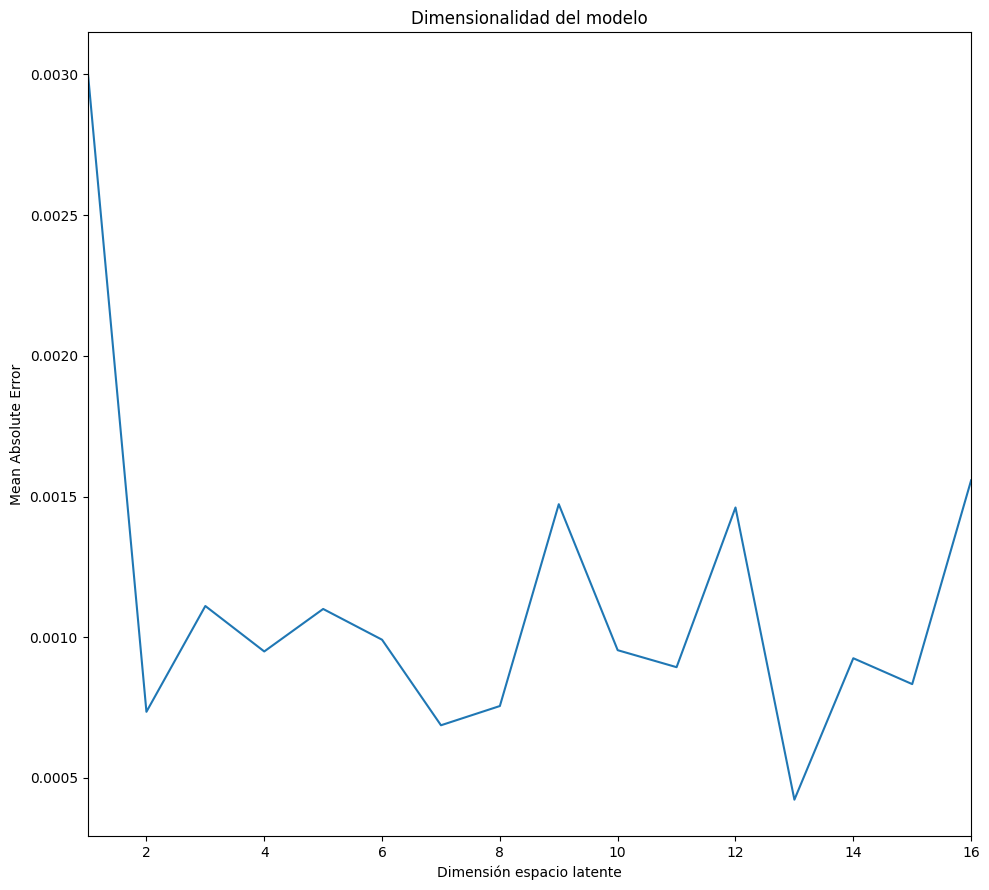

In [ ]:
from matplotlib import pyplot as plt
# Visualizo los errores -  Mean Absolute error
fig, ax = plt.subplots(figsize = (10,9))
ax.plot(range(1, 17), models_scores)
ax.set_title('Dimensionalidad del modelo')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Dimensión espacio latente')
ax.set_xlim((1, 16))
plt.tight_layout()

In [ ]:
kl = KneeLocator(range(1, 17), models_scores, curve="convex", direction="decreasing")
print(f"El como está en dim={kl.elbow}")

El como está en dim=2


In [ ]:
# Get resutls directory path
src_dir = os.path.normpath(os.getcwd() + '/..')
results_dir = os.path.join(src_dir, 'results/spm')

# File name and dir
file_name = 'spm_ld_vae_scores.pkl'
file_dir = os.path.join(results_dir, file_name)

# Save model_scores as pkl
with open(file_dir, 'wb') as f:
   pickle.dump(models_scores, f)